In [26]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cvxopt as opt
from cvxopt import blas, solvers
import pandas as pd

np.random.seed(123)

# Turn off progress printing 
solvers.options['show_progress'] = False

In [27]:
## NUMBER OF ASSETS
n_assets = 4

## NUMBER OF OBSERVATIONS
n_obs = 1000

return_vec = np.random.randn(n_assets, n_obs)

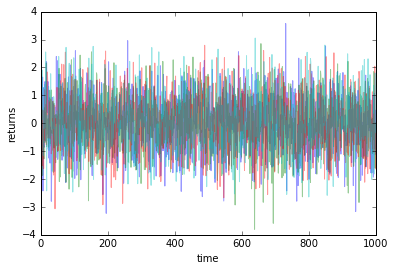

In [28]:
plt.plot(return_vec.T, alpha=.4);
plt.xlabel('time')
plt.ylabel('returns')

In [29]:
def rand_weights(n):
    ''' Produces n random weights that sum to 1 '''
    k = np.random.rand(n)
    return k / sum(k)

print rand_weights(n_assets)
print rand_weights(n_assets)

[ 0.54066805  0.2360283   0.11660484  0.1066988 ]
[ 0.27638339  0.03006307  0.47850085  0.21505269]


In [30]:
def random_portfolio(returns):
    ''' 
    Returns the mean and standard deviation of returns for a random portfolio
    '''

    p = np.asmatrix(np.mean(returns, axis=1))
    w = np.asmatrix(rand_weights(returns.shape[0]))
    C = np.asmatrix(np.cov(returns))
    
    mu = w * p.T
    sigma = np.sqrt(w * C * w.T)
    
    # This recursion reduces outliers to keep plots pretty
    if sigma > 2:
        return random_portfolio(returns)
    return mu, sigma

In [31]:
n_portfolios = 500
means, stds = np.column_stack([
    random_portfolio(return_vec) 
    for _ in xrange(n_portfolios)
])

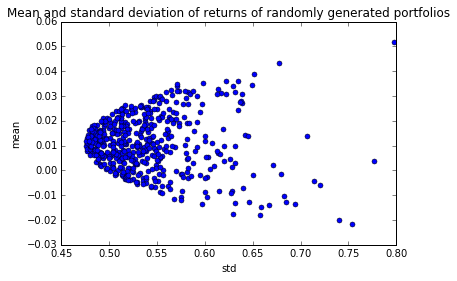

In [32]:
plt.plot(stds, means, 'o', markersize=5)
plt.xlabel('std')
plt.ylabel('mean')
plt.title('Mean and standard deviation of returns of randomly generated portfolios')

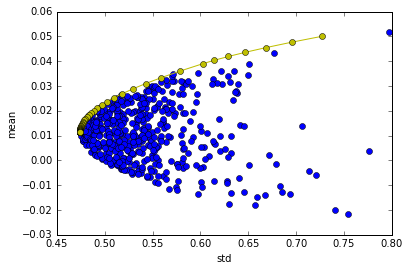

In [33]:
def optimal_portfolio(returns):
    n = len(returns)
    returns = np.asmatrix(returns)
    
    # Calculations are performed over 100 days
    N = 100
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]
    
    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns))
    pbar = opt.matrix(np.mean(returns, axis=1))
    
    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] 
                  for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    return np.asarray(wt), returns, risks

weights, returns, risks = optimal_portfolio(return_vec)

plt.plot(stds, means, 'o')
plt.ylabel('mean')
plt.xlabel('std')
plt.plot(risks, returns, 'y-o')

In [34]:
print weights

[[  2.77880107e-09]
 [  3.20322848e-06]
 [  1.54301198e-06]
 [  9.99995251e-01]]


In [71]:
import datetime

from zipline.utils.factory import load_bars_from_yahoo
end = datetime.datetime(2016, 9, 30)
start = end - 2500 * pd.tseries.offsets.BDay()
data = load_bars_from_yahoo(stocks=['DEVIX','VSMAX','MINJX','TRREX','FIHBX'],
                            start=start, end=end)

/home/tom/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:7: DeprecationWarning: load_bars_from_yahoo is deprecated, please register a yahoo_equities data bundle instead


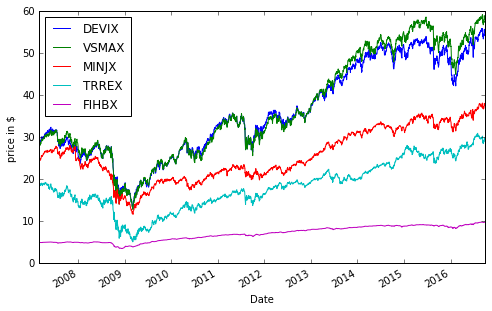

In [72]:
data.loc[:, :, 'price'].plot(figsize=(8,5))
plt.ylabel('price in $')

/home/tom/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:55: ZiplineDeprecationWarning: The `history` method is deprecated.  Use `data.history` instead.


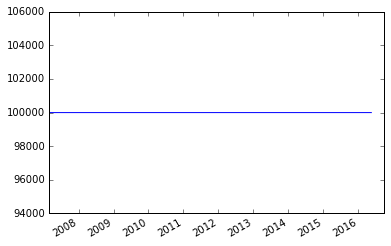

In [74]:
import zipline
from zipline.api import (history, 
                         set_slippage, 
                         slippage,
                         set_commission, 
                         commission, 
                         order_target_percent)

from zipline import TradingAlgorithm


def initialize(context):
    '''
    Called once at the very beginning of a backtest (and live trading). 
    Use this method to set up any bookkeeping variables.
    
    The context object is passed to all the other methods in your algorithm.

    Parameters

    context: An initialized and empty Python dictionary that has been 
             augmented so that properties can be accessed using dot 
             notation as well as the traditional bracket notation.
    
    Returns None
    '''
    # Turn off the slippage model
    set_slippage(slippage.FixedSlippage(spread=0.0))
    # Set the commission model (Interactive Brokers Commission)
    set_commission(commission.PerShare(cost=0.01, min_trade_cost=1.0))
    context.tick = 0
    
def handle_data(context, data):
    '''
    Called when a market event occurs for any of the algorithm's 
    securities. 

    Parameters

    data: A dictionary keyed by security id containing the current 
          state of the securities in the algo's universe.

    context: The same context object from the initialize function.
             Stores the up to date portfolio as well as any state 
             variables defined.

    Returns None
    '''
    # Allow history to accumulate 100 days of prices before trading
    # and rebalance every day thereafter.
    context.tick += 1
    if context.tick < 100:
        return
    # Get rolling window of past prices and compute returns
    prices = history(100, '1d', 'price').dropna()
    
    # pct_change() returns dataframe of % change from one day to next.
    returns = prices.pct_change().dropna()
    try:
        # Perform Markowitz-style portfolio optimization
        weights, _, _ = optimal_portfolio(returns.T)
        # Rebalance portfolio accordingly
        for stock, weight in zip(prices.columns, weights):
            order_target_percent(stock, weight)
    except ValueError as e:
        # Sometimes this error is thrown
        # ValueError: Rank(A) < p or Rank([P; A; G]) < n
        pass
        
# Instantinate algorithm        
algo = TradingAlgorithm(initialize=initialize, 
                        handle_data=handle_data)
# Run algorithm
results = algo.run(data)
results.portfolio_value.plot()

In [75]:
results

,algo_volatility,algorithm_period_return,alpha,benchmark_period_return,benchmark_volatility,beta,capital_used,ending_cash,ending_exposure,ending_value,...,short_exposure,short_value,shorts_count,sortino,starting_cash,starting_exposure,starting_value,trading_days,transactions,treasury_period_return
2007-03-02 21:00:00,0,0,-0.0452,-0.011403,0.000000,0,0,100000,0.000000,0.000000,...,0,0,0,0,100000,0.000000,0.000000,1,[],0.0452
2007-03-05 21:00:00,0,0,-0.0451,-0.020703,0.022395,0,0,100000,0.000000,0.000000,...,0,0,0,0,100000,0.000000,0.000000,2,[],0.0451
2007-03-06 21:00:00,0,0,-0.0453,-0.005530,0.237894,0,0,100000,0.000000,0.000000,...,0,0,0,0,100000,0.000000,0.000000,3,[],0.0453
2007-03-07 21:00:00,0,0,-0.0450,-0.007982,0.194318,0,0,100000,0.000000,0.000000,...,0,0,0,0,100000,0.000000,0.000000,4,[],0.0450
2007-03-08 21:00:00,0,0,-0.0451,-0.000912,0.180188,0,0,100000,0.000000,0.000000,...,0,0,0,0,100000,0.000000,0.000000,5,[],0.0451
2007-03-09 21:00:00,0,0,-0.0459,-0.000235,0.161250,0,0,100000,0.000000,0.000000,...,0,0,0,0,100000,0.000000,0.000000,6,[],0.0459
2007-03-12 20:00:00,0,0,-0.0456,0.002444,0.148074,0,0,100000,0.000000,0.000000,...,0,0,0,0,100000,0.000000,0.000000,7,[],0.0456
2007-03-13 20:00:00,0,0,-0.0450,-0.017974,0.179894,0,0,100000,0.000000,0.000000,...,0,0,0,0,100000,0.000000,0.000000,8,[],0.0450
2007-03-14 20:00:00,0,0,-0.0453,-0.011403,0.174741,0,0,100000,0.000000,0.000000,...,0,0,0,0,100000,0.000000,0.000000,9,[],0.0453
2007-03-15 20:00:00,0,0,-0.0454,-0.007761,0.166576,0,0,100000,0.000000,0.000000,...,0,0,0,0,100000,0.000000,0.000000,10,[],0.0454
